## Ankita replicado

In [1]:
from tqdm import tqdm
import os
import json
import numpy as np
import gc
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import seaborn as sns

In [2]:
def linear_CKA(X, Y):
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    hsic = np.linalg.norm(X_centered.T @ Y_centered, 'fro') ** 2
    var1 = np.linalg.norm(X_centered.T @ X_centered, 'fro')
    var2 = np.linalg.norm(Y_centered.T @ Y_centered, 'fro')

    return hsic / (var1 * var2)

In [5]:
wav_vs_glove = []
with open(os.path.join('../../../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
    glove_list = json.load(f)
glove_matrix = np.array(glove_list)

for i in range(12):
    with open(os.path.join('../../..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        model1_list = json.load(f)
    model1_matrix = np.array(model1_list)
    wav_vs_glove.append(linear_CKA(model1_matrix, glove_matrix)) 

    del model1_list, model1_matrix
    gc.collect()
   
with open(f'cka_glove_wav2vec2.json', 'w') as f:
    json.dump(wav_vs_glove, f)

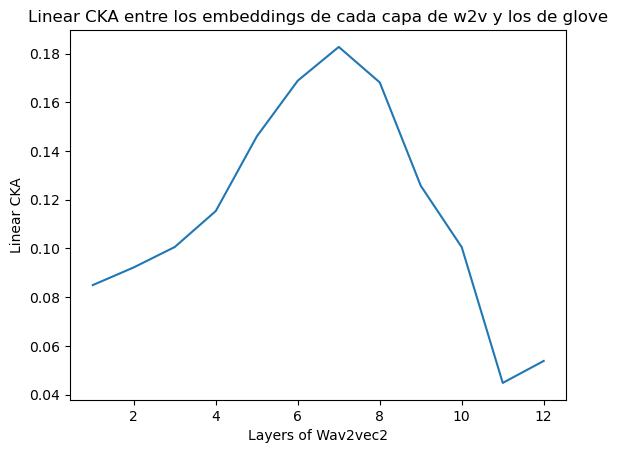

In [6]:
import matplotlib.pyplot as plt

x = range(1,13)
plt.plot(x, wav_vs_glove, label='wav_vs_glove')

plt.xlabel('Layers of Wav2vec2')
plt.ylabel('Linear CKA')
plt.title('Linear CKA entre los embeddings de cada capa de w2v y los de glove')
plt.show()

## CKA: Learning Curve

In [8]:
x_list = []
for i in range(12):
    with open(os.path.join('../../..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        model1_list = json.load(f)
    x_matrix = np.array(model1_list)
    x_list.append(x_matrix) 


In [9]:
from tqdm import tqdm
matrix = np.zeros((15, 12))
for i in tqdm(range(3000, 46000, 3000)):
    index = int((i-3000)/3000)
    for j in tqdm(range(12)): 
        x = x_list[j]
        matrix[index, j] = linear_CKA(x[0:i], glove_matrix[0:i])

100%|██████████| 15/15 [00:28<00:00,  1.92s/it]


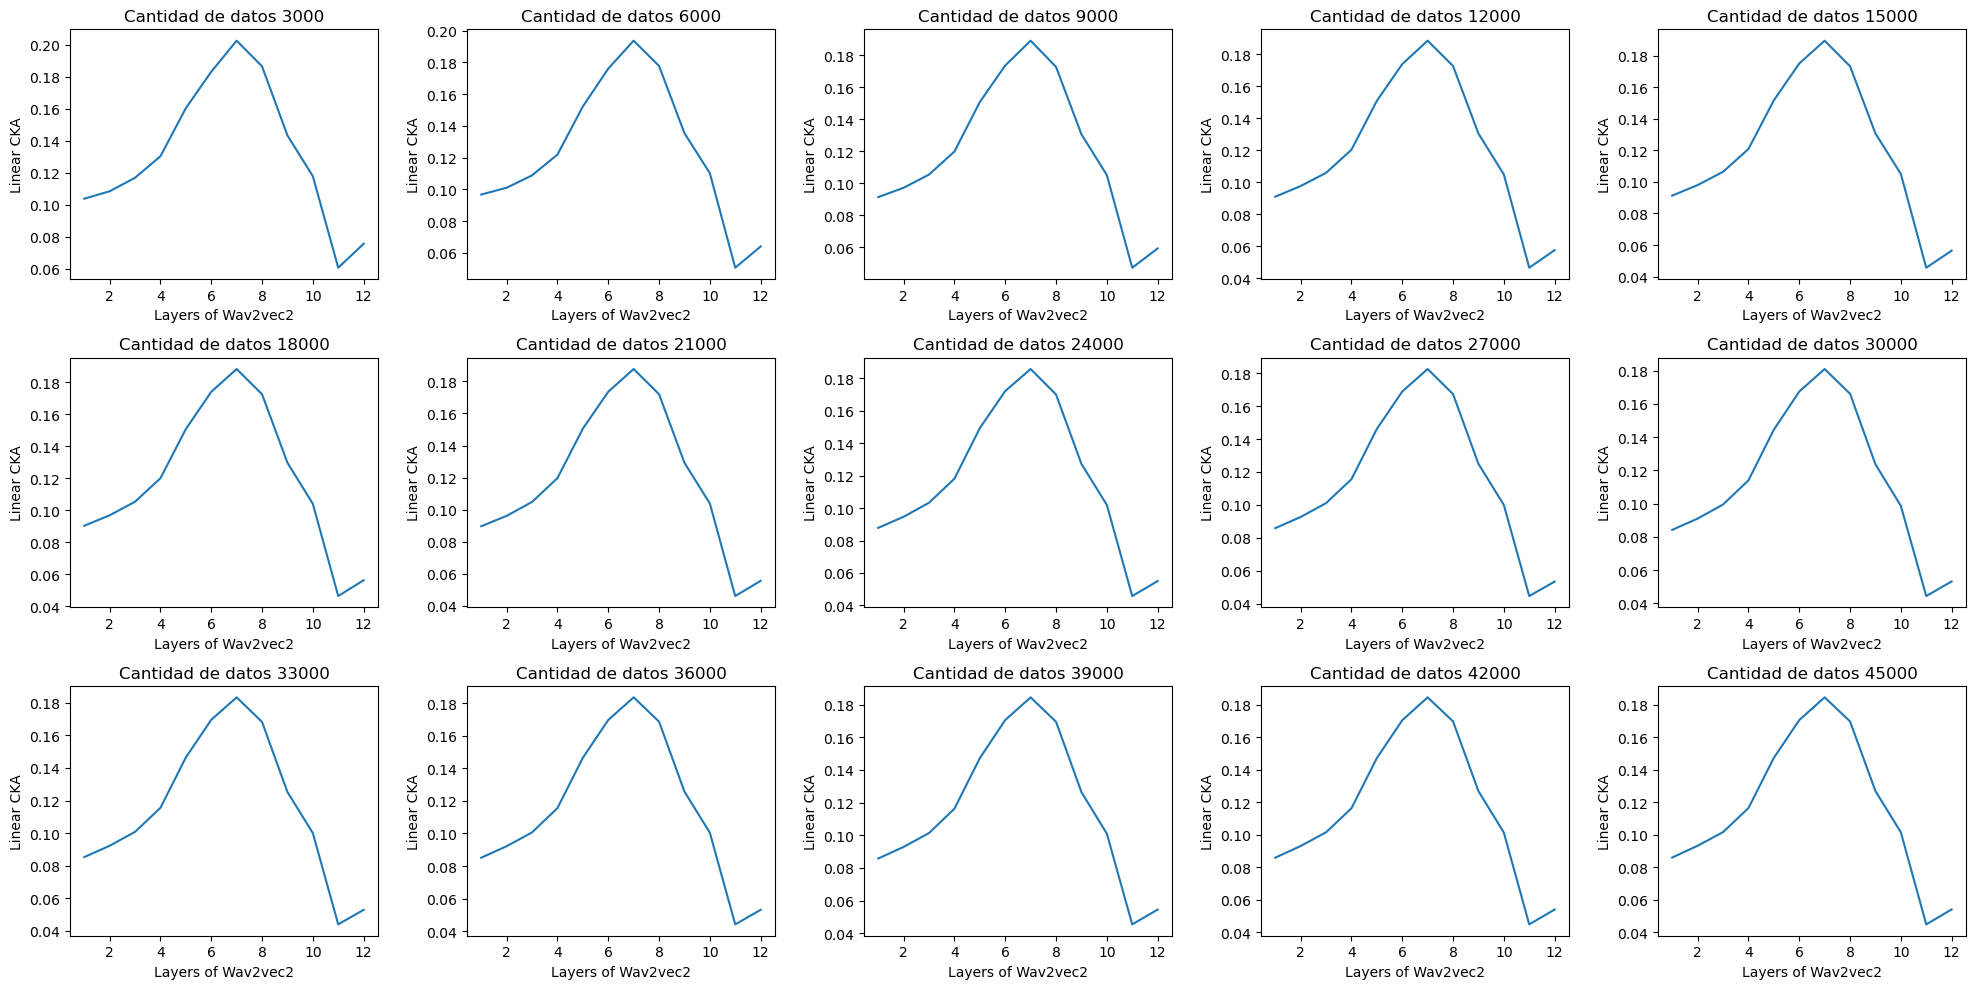

In [10]:
import matplotlib.pyplot as plt

# Assuming 'matrix' is already filled and has shape (15, 11)
# Setting up the figure and the axes grid
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))  # Adjust figsize to fit your screen and needs

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i in range(15):
    x = range(1, 13)  # Layers 1 to 11
    axes[i].plot(x, matrix[i], label=f'wav_vs_glove')
    axes[i].set_xlabel('Layers of Wav2vec2')
    axes[i].set_ylabel('Linear CKA')
    axes[i].set_title(f'Cantidad de datos {(i+1)*3000}')  # Optional: add a title to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


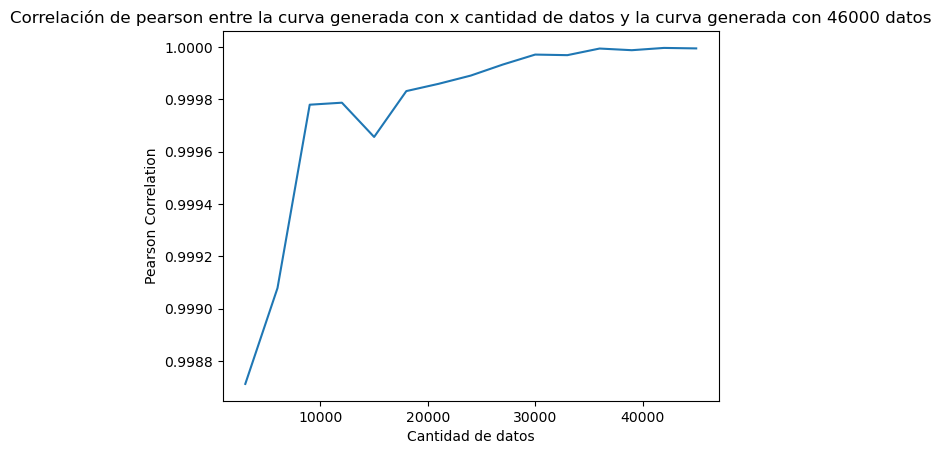

In [11]:

pearson_corr = []
for i in range(matrix.shape[0]):
    pearson_corr.append(stats.pearsonr(wav_vs_glove, matrix[i]).statistic)

plt.plot(range(3000, 46000, 3000), pearson_corr)
plt.xlabel('Cantidad de datos')
plt.ylabel('Pearson Correlation')
plt.title('Correlación de pearson entre la curva generada con x cantidad de datos y la curva generada con 46000 datos')
plt.show()

## CKA vs CCA

In [ ]:
####################### CORRER SOLO SI SE TIENE EL COMPUTO, EN NUESTRO CASO CORRIMOS EN COLAB Y COPIAMOS ABAJO LA RESPUESTA

import os
os.environ['OMP_NUM_THREADS']='8' #Cantidad de threads a usar por sklearn
os.nice(10) #Prioridad de los procesos -20: highest 20: lowest 0: default

# Run this cell in colab and got the following result


wav_vs_glove_CCA = []
with open(os.path.join('../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
    glove_list = json.load(f)
glove_matrix = np.array(glove_list)

for i in range(12):
    x = x_list[i]
    model1_matrix = np.array(model1_list)
    model = CCA(n_components=300)
    model.fit(x[0:3000],glove_matrix[0:3000])
    X_c, Y_c = model.transform(x[0:3000], glove_matrix[0:3000])
    correlations = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=X_c.shape[1])
    mean_correlation = np.mean(correlations)
    wav_vs_glove_CCA.append(mean_correlation)  

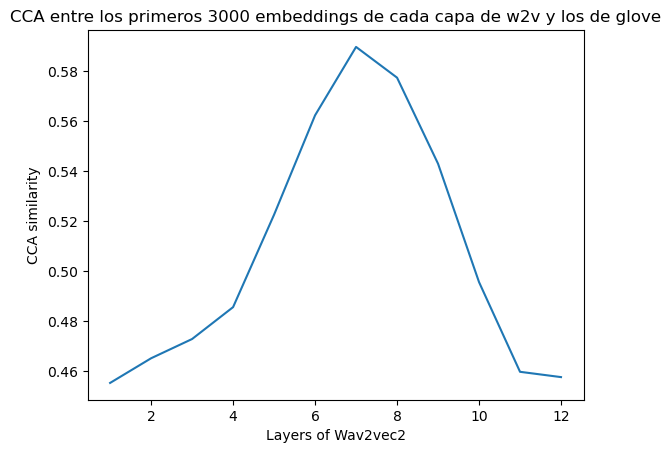

In [12]:

wav_vs_glove_CCA = [0.4552785903820065,
 0.46515271583991935,
 0.4728577455210156,
 0.4856241870508816,
 0.52264089080444,
 0.5624277531077105,
 0.5898141105294815,
 0.5775077350128057,
 0.5430461697056727,
 0.49564927266548353,
 0.45973128155226173,
 0.4576064483370868]

x = range(1,13)
plt.plot(x, wav_vs_glove_CCA, label='wav_vs_glove')

plt.xlabel('Layers of Wav2vec2')
plt.ylabel('CCA similarity')
plt.title('CCA entre los primeros 3000 embeddings de cada capa de w2v y los de glove')
plt.show()

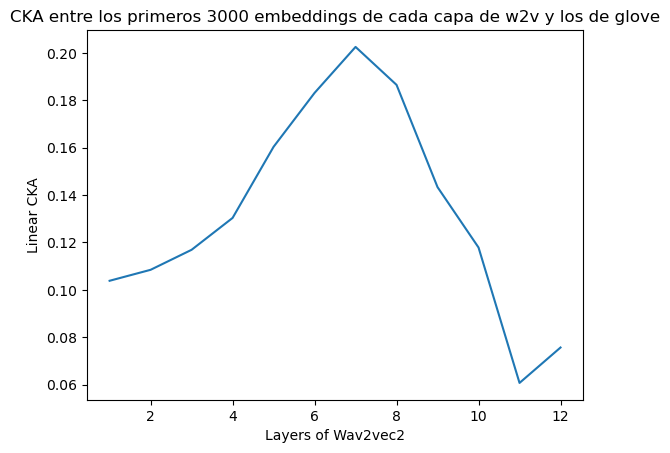

In [13]:
x = range(1,13)
plt.plot(x, matrix[0], label='wav_vs_glove')

plt.xlabel('Layers of Wav2vec2')
plt.ylabel('Linear CKA')
plt.title('CKA entre los primeros 3000 embeddings de cada capa de w2v y los de glove')
plt.show()

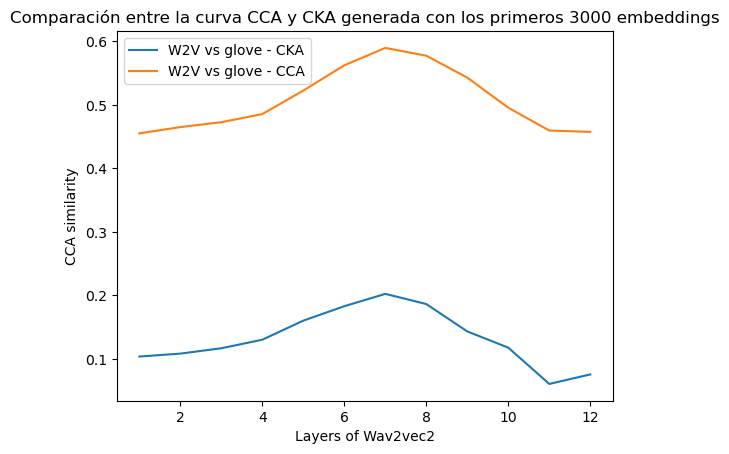

In [14]:
x = range(1,13)
plt.plot(x, matrix[0], label='W2V vs glove - CKA')
plt.plot(x, wav_vs_glove_CCA, label='W2V vs glove - CCA')

plt.xlabel('Layers of Wav2vec2')
plt.ylabel('CCA similarity')
plt.legend()
plt.title('Comparación entre la curva CCA y CKA generada con los primeros 3000 embeddings')
plt.show()

## Bert vs Wav2vec2

In [15]:
with open('cka_wav2vec2_bert-base-uncased.json', 'r') as f:
    wav_vs_bert = json.load(f)
wav_vs_bert_matrix = np.array(wav_vs_bert)

In [16]:
max_values = np.max(wav_vs_bert_matrix, axis=0)  # Find the maximum values in each column
max_indices = np.argmax(wav_vs_bert_matrix, axis=0) # Find the row indices of the maximum values in each column
layeri_layeri = np.diag(wav_vs_bert_matrix)

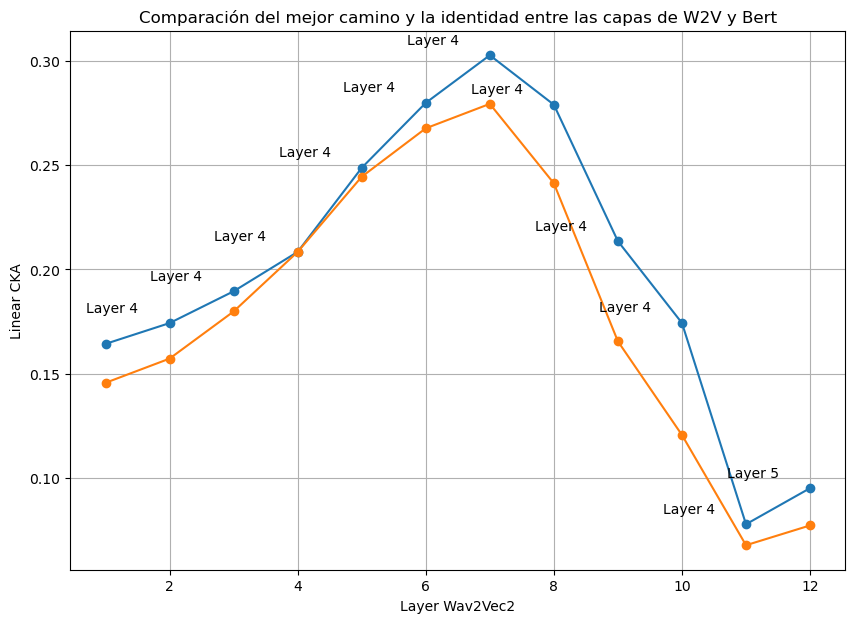

In [17]:
plt.figure(figsize=(10, 7))  
plt.plot(x, max_values, 'o-', label='Mayor CKA de capa i contra todas las capas de bert')  # Plot the maximum values with line and markers
plt.plot(x, layeri_layeri, 'o-', label='Capa i W2V contra capa i Bert')
for i, (value, index) in enumerate(zip(max_values, max_indices)):
    plt.annotate(f'Layer {index+1}', (i, value), textcoords="offset points", xytext=(5,8), ha='center')

plt.title('Comparación del mejor camino y la identidad entre las capas de W2V y Bert')
plt.xlabel('Layer Wav2Vec2')
plt.ylabel('Linear CKA')
plt.grid(True)
plt.show()

# Alcanza el modelo large un valor más alto de CKA comparado con el base?

In [18]:
import json
import numpy as np
with open('cka_wav2vec2_bert-base-uncased.json', 'r') as f:
    wav_vs_bert = np.array(json.load(f))

with open('cka_wav2vec2_large_960_bert-base-uncased.json', 'r') as f:
    wav_vs_bert_large = np.array(json.load(f))

In [20]:
# W2V2 BASE VS BERT
max_value, max_indices = wav_vs_bert.max(), np.unravel_index(wav_vs_bert.argmax(), wav_vs_bert.shape)

max_value, max_indices

(0.3025870284057748, (3, 6))

In [21]:
# W2V2 LARGE VS BERT
max_value_large, max_indices_large = wav_vs_bert_large.max(), np.unravel_index(wav_vs_bert_large.argmax(), wav_vs_bert_large.shape)

max_value_large, max_indices_large

(0.33890519266560837, (3, 12))